In [215]:
# Initial Imports
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [216]:
# reading in the data for top 5 largest economies
df = pd.read_csv('WEOApr2021all.csv')
df = df[
    (df["Units"] == "U.S. dollars") | (df["Units"] == "Percent change") | (df["Units"] == "Percent of GDP") | (df["Units"] == "Persons") | (df["Units"] == "Percent of total labor force")]
df.drop(columns=['WEO Country Code','ISO','WEO Subject Code','Subject Notes','Units','Country/Series-specific Notes','Estimates Start After','Scale'], inplace=True)
df = df.T
df.columns = [df.loc["Country"], df.loc['Subject Descriptor']]
df.drop(['Country','Subject Descriptor'],axis=0,inplace=True)
US_df = df['United States']
china_df =df['China']
japan_df = df['Japan']
india_df = df['India']
germany_df = df['Germany']

# clean numeric data
US_df.dropna(axis=1, inplace=True)
US_df = US_df.replace(',','', regex=True)
US_df = US_df.astype("float")

china_df.dropna(axis=1, inplace=True)
china_df = china_df.replace(',','', regex=True)
china_df = china_df.astype("float")

japan_df.dropna(axis=1, inplace=True)
japan_df = japan_df.replace(',','', regex=True)
japan_df = japan_df.astype("float")

india_df.dropna(axis=1, inplace=True)
india_df = india_df.replace(',','', regex=True)
india_df = india_df.astype("float")

germany_df.dropna(axis=1, inplace=True)
germany_df = germany_df.replace(',','', regex=True)
germany_df = germany_df.astype("float")

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\User\anaconda3\env

In [217]:
#US dataframe cleaned all columns
US_df.head()


Subject Descriptor,"Gross domestic product, constant prices","Gross domestic product, current prices","Gross domestic product per capita, current prices",Total investment,Gross national savings,"Inflation, average consumer prices","Inflation, end of period consumer prices",Volume of imports of goods and services,Volume of Imports of goods,Volume of exports of goods and services,Volume of exports of goods,Unemployment rate,Population,Current account balance,Current account balance
1980,-0.257,2857.33,12552.94,23.310,22.053,13.502,11.887,-6.660,-7.449,10.777,12.292,7.175,227.622,2.316,0.081
1981,2.538,3207.03,13948.70,24.277,23.195,10.378,8.569,2.610,2.041,1.219,-0.655,7.617,229.916,5.031,0.157
1982,-1.802,3343.80,14404.99,22.071,21.706,6.158,4.017,-1.275,-2.524,-7.661,-8.479,9.708,232.128,-5.533,-0.165
1983,4.584,3634.03,15513.68,22.253,19.721,3.160,3.930,12.620,13.593,-2.589,-3.274,9.600,234.247,-38.695,-1.065
1984,7.237,4037.65,17086.44,25.096,21.834,4.368,3.896,24.338,24.183,8.157,7.107,7.508,236.307,-94.342,-2.337


In [218]:
# Created X and y for each country 
US_X = US_df.drop(columns=["Gross domestic product, current prices"])
US_y = US_df['Gross domestic product, current prices']

china_X = china_df.drop(columns=["Gross domestic product, current prices"])
china_y = china_df['Gross domestic product, current prices']

japan_X = japan_df.drop(columns=["Gross domestic product, current prices"])
japan_y = japan_df['Gross domestic product, current prices']

india_X = india_df.drop(columns=["Gross domestic product, current prices"])
india_y = india_df['Gross domestic product, current prices']

germany_X = germany_df.drop(columns=["Gross domestic product, current prices"])
germany_y = germany_df['Gross domestic product, current prices']



In [219]:
# train-test-splits for each country
US_X_train, US_X_test, US_y_train, US_y_test = train_test_split(US_X,US_y, shuffle=False, test_size=0.3)

china_X_train, china_X_test, china_y_train, china_y_test = train_test_split(china_X,china_y)

japan_X_train, japan_X_test, japan_y_train, japan_y_test = train_test_split(japan_X,japan_y)

india_X_train, india_X_test, india_y_train, india_y_test = train_test_split(india_X,india_y)

germany_X_train, germany_X_test, germany_y_train, germany_y_test = train_test_split(germany_X,germany_y)



In [220]:
# create models for each country
US_model = RandomForestRegressor(n_estimators=100, max_depth=3, random_state=0)
US_model.fit(US_X_train, US_y_train)

china_model = RandomForestRegressor(n_estimators=100, max_depth=3, random_state=0)
china_model.fit(china_X_train, china_y_train)

japan_model = RandomForestRegressor(n_estimators=100, max_depth=3, random_state=0)
japan_model.fit(japan_X_train, japan_y_train)

india_model = RandomForestRegressor(n_estimators=100, max_depth=3, random_state=0)
india_model.fit(india_X_train, india_y_train)

germany_model = RandomForestRegressor(n_estimators=100, max_depth=3, random_state=0)
germany_model.fit(germany_X_train, germany_y_train)

RandomForestRegressor(max_depth=3, random_state=0)

In [221]:
US_GDP_Predict = US_model.predict(US_X_test)
US_GDP_Predict

array([14501.19322226, 14359.36408893, 14346.77186393, 14276.21117143,
       14362.19416726, 14316.86306726, 14291.70672143, 14362.19416726,
       14675.23913976, 14489.04465083, 14429.07625143, 14314.04538226,
       14314.04538226, 14297.86874226, 14297.86874226])

In [222]:
US_X_test

Subject Descriptor,"Gross domestic product, constant prices","Gross domestic product per capita, current prices",Total investment,Gross national savings,"Inflation, average consumer prices","Inflation, end of period consumer prices",Volume of imports of goods and services,Volume of Imports of goods,Volume of exports of goods and services,Volume of exports of goods,Unemployment rate,Population,Current account balance,Current account balance
2012,2.249,51563.13,20.021,18.777,2.073,1.822,2.706,2.625,3.407,3.842,8.075,314.121,-418.115,-2.581
2013,1.842,53071.82,20.414,19.201,1.466,1.319,1.544,1.762,3.577,3.183,7.358,316.266,-336.854,-2.007
2014,2.526,55024.66,20.806,20.356,1.615,0.524,4.997,5.562,4.213,4.634,6.158,318.535,-367.819,-2.099
2015,3.076,56848.51,21.163,20.141,0.121,0.695,5.175,5.657,0.421,-0.356,5.275,320.823,-407.355,-2.234
2016,1.711,58017.23,20.415,18.733,1.267,2.179,1.651,1.365,0.296,0.542,4.875,323.095,-394.865,-2.106
2017,2.333,60105.85,20.547,19.216,2.137,2.171,4.656,4.701,3.915,4.056,4.350,325.143,-365.269,-1.869
2018,2.997,63055.98,21.040,19.052,2.434,1.911,4.096,4.950,2.990,4.194,3.892,326.882,-449.694,-2.182
2019,2.161,65253.52,21.014,18.608,1.812,2.063,1.080,0.483,-0.118,-0.104,3.683,328.461,-480.225,-2.241
2020,-3.505,63415.99,20.988,17.802,1.248,1.361,-9.285,-6.062,-12.970,-9.473,8.108,330.086,-646.399,-3.088
2021,6.386,68308.97,21.638,17.523,2.264,2.336,18.868,20.910,10.486,15.235,5.791,331.952,-876.355,-3.865


In [223]:
US_y_test

2012    16197.05
2013    16784.83
2014    17527.28
2015    18238.30
2016    18745.10
2017    19542.98
2018    20611.88
2019    21433.23
2020    20932.75
2021    22675.27
2022    24003.70
2023    24892.61
2024    25790.12
2025    26719.63
2026    27659.15
Name: Gross domestic product, current prices, dtype: float64

In [224]:
from sklearn.metrics import mean_squared_error, r2_score

In [225]:
r2 = r2_score(US_y_test, US_GDP_Predict)
r2

-3.923072526338127

In [226]:
mse = mean_squared_error(US_y_test, US_GDP_Predict)
mse

63020889.99293583

In [227]:
rmse = np.sqrt(mse)
rmse

7938.569769986016

In [228]:
#Biggest Contributor to model prediction
importances = US_model.feature_importances_
sorted(zip(US_model.feature_importances_, US_X.columns), reverse=True)

[(0.3948149046027351, 'Population'),
 (0.29658600110442596, 'Gross domestic product per capita, current prices'),
 (0.2588036191469995, 'Current account balance'),
 (0.010882601976730988, 'Current account balance'),
 (0.01008518440678065, 'Gross national savings'),
 (0.00782537285744775, 'Total investment'),
 (0.005606450980233391, 'Inflation, average consumer prices'),
 (0.004546328528871664, 'Unemployment rate'),
 (0.0034247508428322327, 'Volume of Imports of goods'),
 (0.0019079077911144274, 'Volume of exports of goods and services'),
 (0.0016896429172429297, 'Volume of exports of goods'),
 (0.0014078651875667138, 'Inflation, end of period consumer prices'),
 (0.0013122971231491775, 'Gross domestic product, constant prices'),
 (0.001107072533869582, 'Volume of imports of goods and services')]

<AxesSubplot:title={'center':'Features Importances that Factor Into US GDP'}, ylabel='1'>

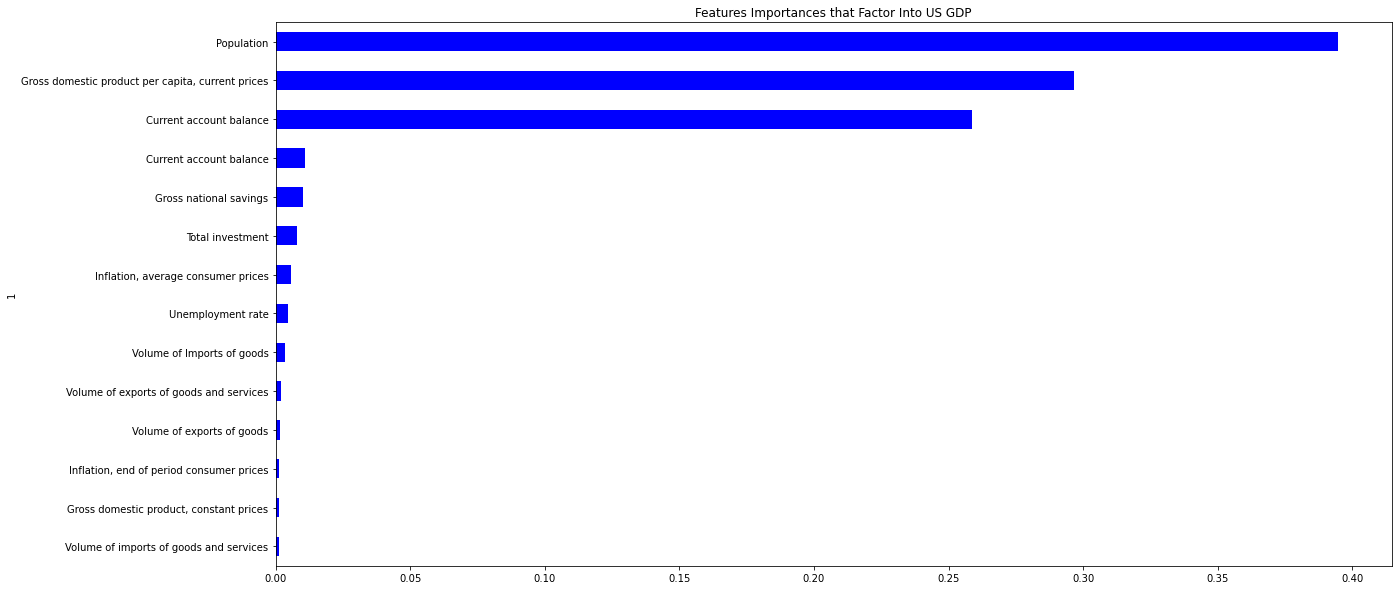

In [229]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(US_model.feature_importances_, US_X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(figsize=(20,10), kind='barh', color='Blue', title= 'Features Importances that Factor Into US GDP', legend=False)

In [230]:
#Accuracy using training data
US_model.score(US_X_train, US_y_train)  

0.9961353948567699

In [231]:
#Accuracy using test data
US_model.score(US_X_test, US_y_test)  

-3.923072526338127

<AxesSubplot:>

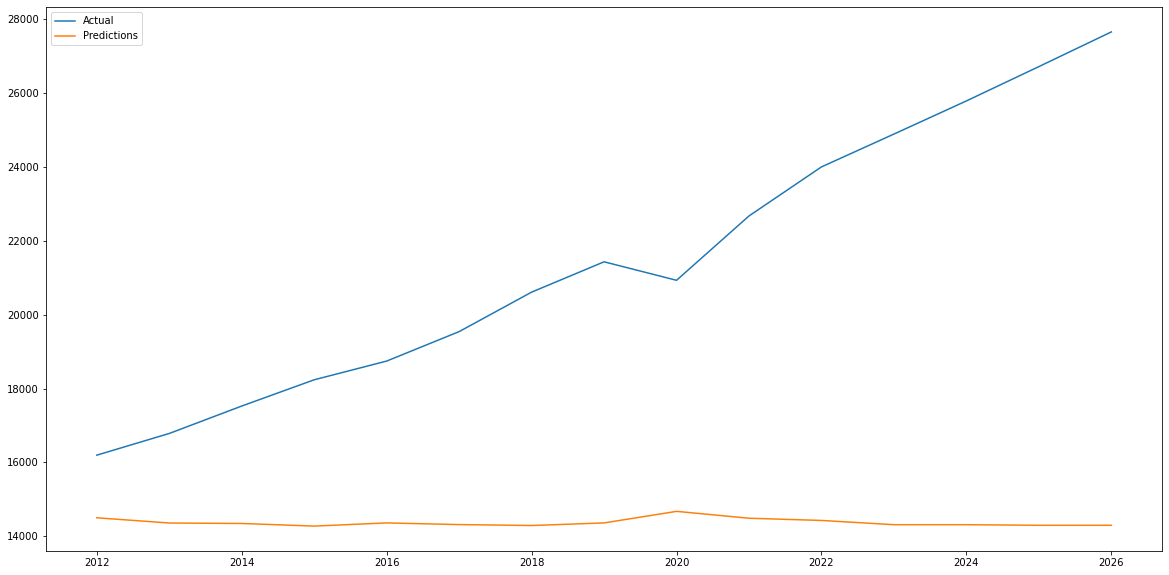

In [232]:
US_pred_results = US_X_test.index.to_frame()
US_pred_results["Actual"] = US_y_test
US_pred_results["Predictions"] = US_GDP_Predict
US_pred_results.sort_index(inplace=True)
US_pred_results.plot(figsize=(20,10))

In [233]:
US_df.shape

(47, 15)

<font size="6"> GDP LSTM Predictive Model </font>

In [187]:
from numpy.random import seed

seed(1)
from tensorflow import random

random.set_seed(2)

<font size="5"> Splitting Data Between Training and Testing Sets </font>

In [190]:
#Use the MinMaxScaler to scale data between 0 and 1.
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(US_X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(US_y.values.reshape(-1,1))
y_train = scaler.transform(y_train.values.reshape(-1,1))
y_test = scaler.transform(y_test.values.reshape(-1,1))



ValueError: Expected 2D array, got 1D array instead:
array=[ 2857.33  3207.03  3343.8   3634.03  4037.65  4339.    4579.63  4855.25
  5236.43  5641.6   5963.13  6158.13  6520.33  6858.55  7287.25  7639.75
  8073.13  8577.55  9062.83  9630.7  10252.35 10581.83 10936.45 11458.25
 12213.73 13036.63 13814.6  14451.88 14712.83 14448.93 14992.05 15542.6
 16197.05 16784.83 17527.28 18238.3  18745.1  19542.98 20611.88 21433.23
 20932.75 22675.27 24003.7  24892.61 25790.12 26719.63].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [137]:
US_X_train = US_X_train.reshape((US_X_train.shape[0], US_X_train.shape[1], 1))
US_X_test = US_X_test.reshape((US_X_test.shape[0], US_X_test.shape[1], 1))
print (f"X_train sample values:\n{US_X_train[:5]} \n")
print (f"X_test sample values:\n{US_X_test[:5]}")

X_train sample values:
[[[ 0.35977807]
  [-0.18350958]
  [-2.82896492]
  [-1.68767302]
  [ 0.02498382]
  [-0.05050149]
  [ 0.35921574]
  [ 0.39765633]
  [ 0.46012536]
  [ 0.41397301]
  [-0.66132021]
  [-2.01394405]
  [ 0.99542133]
  [ 1.16620588]]

 [[ 0.35979761]
  [-0.18350958]
  [-2.82891799]
  [-1.68765622]
  [ 0.02497763]
  [-0.05051901]
  [ 0.35921587]
  [ 0.39765643]
  [ 0.46012491]
  [ 0.41397244]
  [-0.66127345]
  [-2.01394405]
  [ 0.99542133]
  [ 1.16621512]]

 [[ 0.35976727]
  [-0.18350958]
  [-2.82902506]
  [-1.68767813]
  [ 0.02496926]
  [-0.05054304]
  [ 0.35921581]
  [ 0.39765638]
  [ 0.46012449]
  [ 0.4139721 ]
  [-0.66105226]
  [-2.01394405]
  [ 0.99542133]
  [ 1.16617598]]

 [[ 0.35981192]
  [-0.18350958]
  [-2.82901623]
  [-1.68770733]
  [ 0.02496332]
  [-0.0505435 ]
  [ 0.359216  ]
  [ 0.39765655]
  [ 0.46012473]
  [ 0.41397233]
  [-0.66106368]
  [-2.01394405]
  [ 0.99542133]
  [ 1.16606658]]

 [[ 0.35983047]
  [-0.18350958]
  [-2.82887824]
  [-1.68767625]
  [ 0.024

In [138]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [158]:
model = Sequential()

number_units = 10
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(US_X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output layer
model.add(Dense(1))

In [159]:
model.compile(optimizer="adam", loss="mean_squared_error")

In [160]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 14, 10)            480       
_________________________________________________________________
dropout_12 (Dropout)         (None, 14, 10)            0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 14, 10)            840       
_________________________________________________________________
dropout_13 (Dropout)         (None, 14, 10)            0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 10)                840       
_________________________________________________________________
dropout_14 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

In [171]:
model.fit(US_X_train, US_y_train, epochs=10, shuffle=False, batch_size=1, verbose=1)

Epoch 1/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0269
Epoch 2/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0266
Epoch 3/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0273
Epoch 4/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0260
Epoch 5/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0270
Epoch 6/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0283
Epoch 7/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0290
Epoch 8/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0278
Epoch 9/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0258
Epoch 10/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0281


In [172]:
model.evaluate(US_X_test, US_y_test)

1/1 [==============================] - 0s 12ms/step - loss: 0.2874


0.2874434292316437

In [173]:
predicted = model.predict(US_X_test)

In [174]:
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(US_y_test.reshape(-1, 1))

In [175]:
GDP = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
    }, index = df.index[-len(real_prices): ])
GDP

,Real,Predicted
2012,16197.05,8643.488281
2013,16784.83,8643.487305
2014,17527.28,8643.475586
2015,18238.30,8643.467773
2016,18745.10,8643.466797
2017,19542.98,8643.464844
2018,20611.88,8643.457031
2019,21433.23,8643.457031
2020,20932.75,8643.487305
2021,22675.27,8643.457031


<AxesSubplot:>

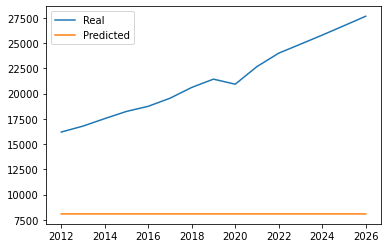

In [177]:
stocks.plot()